# Finding the right threshold

Install pandas and matplotlib on the server. We are going to use these libraries to plot graph. 

In [1]:
# check the libraries in already installed on the cluster 

sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1592149500031_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.9.0  
boto                       2.49.0 
jmespath                   0.9.5  
lxml                       4.5.0  
mysqlclient                1.4.2  
nltk                       3.4.5  
nose                       1.3.4  
numpy                      1.16.5 
pip                        9.0.1  
py-dateutil                2.2    
python37-sagemaker-pyspark 1.3.0  
pytz                       2019.3 
PyYAML                     5.3.1  
setuptools                 28.8.0 
six                        1.13.0 
soupsieve                  1.9.5  
wheel                      0.29.0 
windmill                   1.6

In [2]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/7e/ab/ea76361f9d3e732e114adcd801d2820d5319c23d0ac5482fa3b412db217e/pandas-0.25.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/31/b9/6202dcae729998a0ade30e80ac00f616542ef445b088ec970d407dfd41c0/kiwisolver-1.2.0-cp37-cp37m-manylinux1_x86_64.whl

In [3]:
# Read the data from the result data frame you created. 

result_test = spark.read.parquet('s3a://logistic-data/testresult1.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#result_test.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['click', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C19', 'C20', 'C21', 'dayofweek', 'day', 'hour', 'y', 'pub_category', 'C20_1', 'C20_1int', 'pub_category_ix', 'C15Enc', 'C21Enc', 'device_conn_typeEnc', 'C19Enc', 'pub_category_ixEnc', 'device_typeEnc', 'C1Enc', 'C16Enc', 'C18Enc', 'banner_posEnc', 'C20_1intEnc', 'user_count', 'user_hour_count', 'features', 'rawPrediction', 'probability', 'prediction']

In [5]:
# Create a new data frame with only the columns y and probabilities 

thresh = result_test.select('y','probability')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#thresh.collect()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(y=0, probability=DenseVector([0.8792, 0.1208]))

In [7]:
# the probability is a dense vector column. 
# You will have to find a way to access the value of the probability referring to the positive class. 
# create a function to access the probability of the positive class form the 'probability' column


from pyspark.sql.functions import udf, when
from pyspark.sql.types import FloatType

element_extrac=udf(lambda v:float(v[1]),FloatType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# create a list of all the thresholds you want to check the metrics for. 

result_list = []       # to store the values of precision and recall



threshold_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
#threshold_list

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]

In [9]:
# Now you have the probabilities, your task is to add a class column. 
# To create this column, compare the probabilities with the threshold and decide the class. 
# You can make a loop which will repeat the same action for different thresholds
# Use the filter and count functions to find the true positives, false positives, false negatives. (inside the loop)
# Using these values, find the precision and recall for different thresholds. (inside the loop)


for i in threshold_list:
    test_pred = thresh.withColumn('label_p',when(element_extrac(thresh["probability"]) >= i, 1).otherwise(0))
    TP = test_pred.filter("y==1 AND label_p==1").count()
    FP = test_pred.filter("y==0 AND label_p==1").count()
    FN = test_pred.filter("y==1 AND label_p==0").count()
    TN = test_pred.filter("y==0 AND label_p==0").count()    
    recall = (TP/(TP+FN))
    presession = ((TP/(TP+FP)))
    list1 = []
    list1.append(i)
    list1.append(presession)
    list1.append(recall)
    list1.append(TP)
    list1.append(TN)
    list1.append(FP)
    list1.append(FN)
    result_list.append(list1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Create a panadas datafarme for the list of the output. 

In [11]:
# Create a panadas datafarme for the list of the output. 

# create a schema for the dataframes 
from pyspark.sql.types import *

schema = StructType([StructField('threshold', FloatType(), True),
                      StructField('precision', FloatType(), True),
                      StructField('recall', FloatType(), True),
                      StructField('TP', IntegerType(), True),
                      StructField('TN', IntegerType(), True),
                      StructField('FP', IntegerType(), True),
                      StructField('FN', IntegerType(), True)])


# create a rdd from the list
rdd = spark.sparkContext.parallelize(result_list)


# create a spark dataframe form rdd
thresh_df = spark.createDataFrame(rdd,schema)

# create pandas dataframe form the spark dataframe 
pandas_df = thresh_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

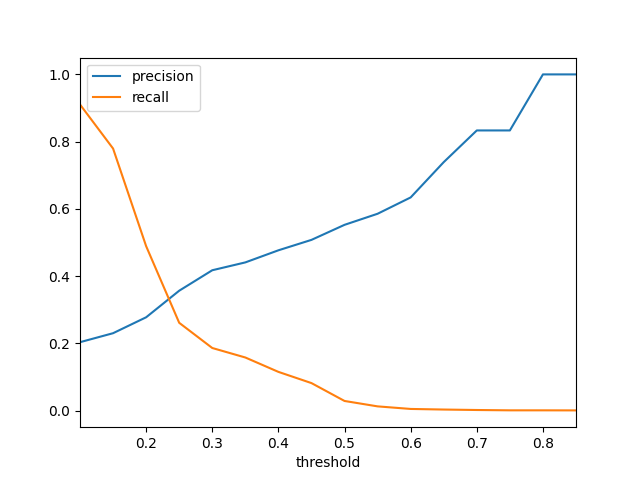

In [12]:
# import matplot lib 
import matplotlib.pyplot as plt

# create the plot
pandas_df.plot.line(x='threshold', y=['precision','recall'])

# display the plot
%matplot plt

In [13]:
total_number = thresh.count()                  # count the total number of readings
positives = thresh.filter("y==1").count()      # count the total number of actual positives

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Business relevance of threshold

In [14]:
final_df = thresh_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
from pyspark.sql.functions import lit

# add columns to represent the total number of readings and total number of positives. 
final_df = final_df.withColumn('total',lit(total_number))
final_df = final_df.withColumn('actual_positives',lit(positives))

# add a column with total number pf predictions for each threshold
final_df = final_df.withColumn('predicted_positives',final_df['TP']+final_df['FP'])

# calculate the amount spend on advertising
# assuming 25 rs per ad
final_df = final_df.withColumn('ad_spend',final_df['predicted_positives']*25) 

# calculate the money spent per ad.
final_df = final_df.withColumn('spend/conversion',final_df['ad_spend']/final_df['TP']) 


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
from pyspark.sql.functions import format_number

final_df.select(final_df['threshold'],
                format_number(final_df['precision'],3).alias('precision'),
                format_number(final_df['recall'],3).alias('recall'),
                'total',
                'actual_positives',
                'predicted_positives',
                'ad_spend',
                final_df['TP'].alias('conversions'),
                format_number(final_df['spend/conversion'],3).alias('spend/conversion')              
               ).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+------+-----+----------------+-------------------+--------+-----------+----------------+
|threshold|precision|recall|total|actual_positives|predicted_positives|ad_spend|conversions|spend/conversion|
+---------+---------+------+-----+----------------+-------------------+--------+-----------+----------------+
|      0.1|    0.204| 0.911|30075|            5098|              22796|  569900|       4642|         122.770|
|     0.15|    0.230| 0.780|30075|            5098|              17251|  431275|       3974|         108.524|
|      0.2|    0.278| 0.489|30075|            5098|               8981|  224525|       2494|          90.026|
|     0.25|    0.357| 0.261|30075|            5098|               3734|   93350|       1332|          70.083|
|      0.3|    0.418| 0.186|30075|            5098|               2275|   56875|        950|          59.868|
|     0.35|    0.441| 0.158|30075|            5098|               1828|   45700|        806|          56.700|
|      0.4

### interpretation 

Find a balance between ad_spent conversions. 
As the number of conversion increases as the spent money also increases. 
As the threshold decreases the money spent per ad also increases. 

###### NOTE: Ad spent is calculated by assuming 25 rs per ad. (fictitious number)

#### A business decisions: 
How much money are you ready to spend per conversion?

Is number of conversion more important than money spent?

Does sending the ad to people who are not going to click in it cause any negative impact?